In [2]:
import json

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

In [3]:
file_name = dict(dev="dev.json", test="test.json", train="train.json")

data_path = "./round1_training_data/"

# read data
data = dict()
for key in file_name:
    with open(data_path + file_name[key], "r") as f:
        data[key] = json.load(f)
data["train"][:5]

[{'ID': '0',
  '产品名': '优医保·高端门诊住院医疗',
  '条款': '【中国境内】 指除香港特别行政区、澳门特别行政区以及台湾地区之外的中华人民共和国领土。',
  '问题': '【中国境内】在优医保·高端门诊住院医疗保险产品中指的是哪些地区？',
  '答案': '在优医保·高端门诊住院医疗保险产品中，【中国境内】指的是除香港特别行政区、澳门特别行政区以及台湾地区之外的中华人民共和国领土。'},
 {'ID': '1',
  '产品名': '同佑e生(臻享版)终身重疾险',
  '条款': '中度再生障碍性贫血 指因骨髓造血功能慢性持续性衰竭导致的贫血、中性粒细胞减少及血小板减少。须满足下列至少一项条件,但未达到本合同所指重大疾病“重型再生障碍性贫血”的给付标准：1.骨髓刺激疗法至少一个月；2.免疫抑制剂治疗至少一个月。',
  '问题': '中度再生障碍性贫血会导致哪些症状？',
  '答案': '中度再生障碍性贫血会导致贫血、中性粒细胞减少及血小板减少。'},
 {'ID': '2',
  '产品名': '众民保·百万医疗（免健告）',
  '条款': '认可的互联网药店 经保险人审核认可，取得互联网药品信息服务资格证书，为被保险人提供购药或者配送服务的药店，具体名单在保险人官方网站或销售平台公示。',
  '问题': '互联网药店需要取得哪种证书才能被保险公司认可？',
  '答案': '互联网药店需要取得互联网药品信息服务资格证书才能被保险公司认可。'},
 {'ID': '3',
  '产品名': '健康福·重疾险（保1年）',
  '条款': '⻆膜移植 指因疾病或意外伤害导致视⼒障碍，已经实际接受了同种（⼈类）异体⻆膜移植⼿术。⻆膜移 植⼿术包括全层⻆膜移植术、板层⻆膜移植术和⻆膜内⽪移植术。单纯⻆膜细胞移植，⾃体⻆膜缘细胞移植，⾮同种来源⻆膜或⼈⼯⻆膜的移植不在本保障范围内。',
  '问题': "什么情况下的角膜移植手术会被保险产品'健康福·重疾险（保1年）'所覆盖？",
  '答案': "因疾病或意外伤害导致视力障碍，并且已经实际接受了同种（人类）异体角膜移植手术的情况，会被保险产品'健康福·重疾险（保1年）'所覆盖。"},
 {'ID': '4',
  '产品名': '保稳盈 | 新华养老盈佳人生(稳健)',
  '条

In [9]:
for idx, item in enumerate(data["test"]):
    tot_len = 0
    # print(item)
    for val in list(item.values())[1:]:
        tot_len += len(val)
    print(idx, tot_len)

0 256
1 357
2 121
3 882
4 194
5 253
6 189
7 483
8 366
9 133
10 378
11 230
12 740
13 419
14 106
15 451
16 122
17 130
18 243
19 3604
20 725
21 467
22 110
23 179
24 165
25 245
26 158
27 415
28 169
29 750
30 1864
31 213
32 145
33 518
34 311
35 173
36 204
37 92
38 543
39 526
40 374
41 258
42 164
43 226
44 186
45 125
46 571
47 179
48 1213
49 325
50 64
51 446
52 151
53 966
54 88
55 186
56 884
57 164
58 495
59 306
60 211
61 189
62 430
63 181
64 72
65 458
66 106
67 707
68 2924
69 520
70 75
71 256
72 244
73 127
74 452
75 369
76 128
77 657
78 290
79 306
80 202
81 356
82 79
83 305
84 602
85 575
86 670
87 49
88 181
89 418
90 170
91 171
92 319
93 79
94 89
95 232
96 274
97 131
98 900
99 167
100 195
101 224
102 323
103 558
104 973
105 1819
106 107
107 216
108 422
109 306
110 1348
111 134
112 120
113 279
114 560
115 197
116 83
117 461
118 371
119 168
120 916
121 537
122 369
123 362
124 78
125 386
126 168
127 100
128 170
129 452
130 165
131 849
132 331
133 1886
134 127
135 1330
136 437
137 215
138 444
1

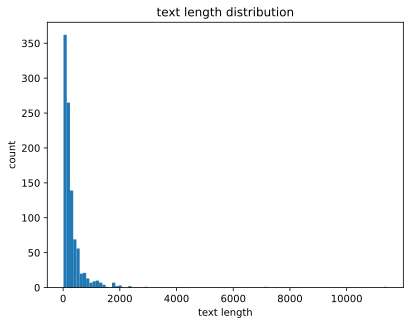

In [3]:
def plot_text_len_distribution(data, split="train"):
    text_len = [len(item["条款"]) for item in data[split]]
    plt.hist(text_len, bins=100)
    plt.title("text length distribution")
    plt.xlabel("text length")
    plt.ylabel("count")
    plt.show()


plot_text_len_distribution(data, split="dev")